# HW 4

This is the main part of HW4.

We start with the usual imports.

In [1]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline
import seaborn as sns                                   # For pretty plots

In [2]:
filenameProcessed = 'Data_Processed.csv'
df = pd.read_csv(filenameProcessed)

In [3]:
df.head(1)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater1,rater2,refNum,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.25,0.0,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [4]:
df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp',
       'seExp'],
      dtype='object')

# Convert Columns to Float

To use the random forest classifier (see below), we must convert all entries to floats. We chose not to do this in the dataprocessing because we want to be able to convert it back to the real categories. The classifier is robust to such categorical data transformation (i.e. we can assign numbers to categories without implying the meaning that one category is twice as important as another category (because the assigned integer is twice as large)).

In [5]:
dfRealCategories = df
categ = df['player'].astype('category')
a = pd.unique(categ.cat.codes)
a.sort()
a

array([   0,    1,    2, ..., 1569, 1570, 1571])

In [6]:
for column_name in df.columns:
    print(column_name)
    if not (df[column_name].dtype in ['int64', 'float64']):
        #print("num ))))))))))))))))))))))")
        df[column_name] = df[column_name].astype('category').cat.codes

playerShort
player
club
leagueCountry
birthday
height
weight
position
games
victories
ties
defeats
goals
yellowCards
yellowReds
redCards
photoID
rater1
rater2
refNum
Alpha_3
meanIAT
nIAT
seIAT
meanExp
nExp
seExp


In [7]:
df[df.isnull().any(axis=1)].head(4)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater1,rater2,refNum,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
47,488,737,58,1,270,179.0,NaN,-1,1,0,...,0.25,0.25,7,33,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
115,97,18,6,0,332,180.0,74.0,6,1,0,...,0.50,0.50,19,74,NaN,NaN,NaN,NaN,NaN,NaN
116,116,1564,66,3,609,180.0,70.0,8,1,1,...,0.25,0.25,19,74,NaN,NaN,NaN,NaN,NaN,NaN
117,150,497,34,0,209,181.0,74.0,8,1,1,...,0.50,0.50,19,74,NaN,NaN,NaN,NaN,NaN,NaN


We need to remove the nans because the random forest does not know what to do otherwise.

Here, we choose to replace them by -1, hoping for the random forest to recognize them. (We could also choose to replace the values by the median where applicable).

In [8]:
df = df.fillna(value=-1)

In [9]:
df.head(3)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater1,rater2,refNum,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,392,34,0,360,182.0,71.0,1,1,0,...,0.25,0.00,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1,44,425,48,0,446,187.0,80.0,6,1,1,...,0.00,0.25,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752
2,63,440,54,0,158,180.0,68.0,4,1,0,...,1.00,1.00,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752


We get the features X and the prediction y. We need to multiply by 4 or 8 to get integer numbers because the classifiers will only accept integers (we could also convert to category codes as above).

In [10]:
df['rater1'].astype('category').cat.categories

Float64Index([0.0, 0.25, 0.5, 0.75, 1.0], dtype='float64')

In [11]:
X = df.drop(['rater1', 'rater2'],axis=1)
y1 = np.asarray((df['rater1'].values)*8).astype('int')
y2 = np.asarray((df['rater2'].values)*8).astype('int')

y_avg = (df['rater1'] + df['rater2']) / 2
print(y_avg.head(3))
y_avg = np.asarray((y_avg.values)*8).astype('int')
print(y_avg[:3])

0    0.125
1    0.125
2    1.000
dtype: float64
[1 1 8]


For later, we define the convention that values 4-8 mean "black person" and vice versa for "white person".

In [12]:
X.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,redCards,photoID,refNum,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,392,34,0,360,182.0,71.0,1,1,0,...,0,1080,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1,44,425,48,0,446,187.0,80.0,6,1,1,...,0,1174,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752
2,63,440,54,0,158,180.0,68.0,4,1,0,...,0,802,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752
3,88,454,49,0,569,193.0,80.0,5,1,0,...,0,490,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752
4,102,456,2,2,563,180.0,70.0,9,1,1,...,0,1035,4,53,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [13]:
y1[:3]

array([2, 0, 8])

In [14]:
y2[:3]

array([0, 2, 8])

In [15]:
y_avg[:3]

array([1, 1, 8])

# Machine Learning

We first look at the following material to help us use scikit.

https://github.com/justmarkham/scikit-learn-videos

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [16]:
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score

We use cross-validation over 10-folds to get good testing accuracy. This only involves passing the fitting object and the function $\textrm{cross_val_score}$ will then do the rest. We will start with knn (k-nearest neighbours).

In [17]:
k_range = list(range(1,3))#list(range(1, 31))
k_scores = []
for k in k_range:
    print("Doing k={}".format(k))
    knn = KNeighborsClassifier(n_neighbors=k)
    #knn.fit(X, y1)
    scores = cross_val_score(knn, X, y1, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

Doing k=1
Doing k=2
[0.68425533400592742, 0.65710874634426275]


# Using Random Forests

We see that we only get 68% and 65% training accuracy with knn. This is probably because we don't know much about the data. For this, random forests prove useful.

We cite Wikipedia because we think it captures well the spirit of our approach:


Decision trees are a popular method for various machine learning tasks. Tree learning "come[s] closest to meeting the requirements for serving as an off-the-shelf procedure for data mining", say Hastie et al., because it is invariant under scaling and various other transformations of feature values, is robust to inclusion of irrelevant features, and produces inspectable models. However, they are seldom accurate.[3]:352
In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, i.e. have low bias, but very high variance. Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance.[3]:587–588 This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.

## Influence of different parameters on RandomForestClassifier

We choose to train on $y_{avg}$ because it seems to best reflect the rating because we have no way of telling whether rater1 or rater2 is correct. Another approach would be to separately fit two models to rater1 and rater2, apply each model to new input data, and to take the average rating in the end, but this claims that rater1 and rater2 have different characteristics. Fitting the models to data where half of the raters were interchanged would lead to different models, which is strange.

Note that the choice of the metric is important because our distribution is highly skewed, i.e. there are much more data samples with white skin colors than the opposite, see the data exploration part. We repeat the essential step here.

In [18]:
def getBlackStatistics(y_vec):
    nbBlack = sum(y_vec >= 4)
    nbTotal = len(y_vec)
    percentBlack = round(nbBlack / nbTotal * 100);
    return (nbBlack, nbTotal, percentBlack)

print("y1: {} black out of {} ({}%)".format(*getBlackStatistics(y1)))
print("y2: {} black out of {} ({}%)".format(*getBlackStatistics(y2)))
print("y_avg: {} black out of {} ({}%)".format(*getBlackStatistics(y_avg)))

y1: 28319 black out of 113862 (25.0%)
y2: 29550 black out of 113862 (26.0%)
y_avg: 26310 black out of 113862 (23.0%)


We see that the prediction accuracy is not the good measure here (but it is not the most terrible either), hence we choose the F1 score, see https://en.wikipedia.org/wiki/F1_score. A F1-score close to 1 is good. The syntax of the F1-score is:

f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)

We can look at the confusion matrix that is the generalization of the F1-score to more than two labels (see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). The f1_score function below is summing over the entries of the confusion matrix. Note, we can also pass the "scoring=f1_weighted" to the cross_val_score function, but this weights less the underrepresented class and we don't want this.

Below, we could also use average="macro", this takes the average of the F1-scores per class. In the end, we chose to take average="micro" because "macro" sets to 0 the F1-score of the classes that are not predicted which is not what we want. We have left commented the version where

In [19]:
from sklearn.metrics import precision_recall_fscore_support

labels = set(range(0,8+1))

def f1_score_modif(estimator, X, y_true):
    # estimator ignored
    y_pred = estimator.predict(X)
    
    #score = precision_recall_fscore_support(y_true, y_pred)
    score = f1_score(y_true, y_pred, average='micro')
    
    #score = f1_score(y_true, y_pred, average='macro')
    # get average per class
    #score = f1_score(y_true, y_pred, average=None)
    
    # suppose that 0 F-score 
    #y_pred[y_pre]
    #predicted_samples_indices = list(map(set(y_pred))
    #avg_score = score[predicted_samples_indices].mean()
    #return avg_score
    
    return score

In [20]:
newLabels = labels.difference(set(range(3)))
labels
newLabels

{3, 4, 5, 6, 7, 8}

Let's see how different parameters passed to the random forest classifier change the prediction accuracy.

In [21]:
params = [  
    {'n_estimators': 10, 'max_depth': 2},
    {'n_estimators': 10, 'max_depth': 8},
    {'n_estimators': 20, 'max_depth': 2},
    {'n_estimators': 20, 'max_depth': 8},
    {'n_estimators': 10, 'max_depth': 2, 'bootstrap': False},
    {'n_estimators': 10, 'max_depth': 12, 'max_features': 20},
    #{} # no params
         ]
    
for paramset in params:
    print("Params: {}".format(paramset))
    forest = RandomForestClassifier(**paramset)
    scores = cross_val_score(forest, X, y_avg, cv=10, scoring=f1_score_modif)
    print("Score: {}".format(scores.mean()))

Params: {'max_depth': 2, 'n_estimators': 10}
Score: 0.3360024895435623
Params: {'max_depth': 8, 'n_estimators': 10}
Score: 0.5545539346617672
Params: {'max_depth': 2, 'n_estimators': 20}
Score: 0.341675463927111
Params: {'max_depth': 8, 'n_estimators': 20}
Score: 0.5716446267245293
Params: {'bootstrap': False, 'max_depth': 2, 'n_estimators': 10}
Score: 0.3376008584045772
Params: {'max_features': 20, 'max_depth': 12, 'n_estimators': 10}
Score: 0.9599613173851564


From the above, we see that it is important to have a sufficiently large max_depth. Let's see what no params at all do. Then, the classifier will choose itself.

In [22]:
forest = RandomForestClassifier()
scores = cross_val_score(forest, X, y_avg, cv=10, scoring=f1_score_modif)
print("Score: {}".format(scores.mean()))

Score: 0.9933061170112614


In [23]:
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Unfortunately, the default "forest" has a lot of parameters that are implicitly specified, but we see that there is no depth restriction which seems is important as above. The default random forest classifier performs better than what we did above.

In [24]:
n_estimators_range = [1, 2, 3, 5, 10, 20, 30, 50]
k_scores = []
for n_estim in n_estimators_range:
    print("Doing n_estim={}".format(n_estim))
    forest = RandomForestClassifier(n_estimators = n_estim)
    scores = cross_val_score(forest, X, y1, cv=10, scoring=f1_score_modif)
    k_scores.append(scores.mean())
print(k_scores)

Doing n_estim=1
Doing n_estim=2
Doing n_estim=3
Doing n_estim=5
Doing n_estim=10
Doing n_estim=20
Doing n_estim=30
Doing n_estim=50
[0.97757821265376799, 0.96464849665227015, 0.99078646987973773, 0.99476535019466739, 0.99728590013968277, 0.99935887409099211, 0.99939398490105058, 0.99960477470480547]


In [25]:
depth_range = [1, 2, 3, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40]
k_scores_depth = []
for depth in depth_range:
    print("Doing depth={}".format(depth))
    forest = RandomForestClassifier(n_estimators = 10, max_depth=depth)
    scores = cross_val_score(forest, X, y1, cv=20, scoring=f1_score_modif)
    print(scores)
    k_scores_depth.append(scores.mean())
print(k_scores_depth)

Doing depth=1
[ 0.44073749  0.42493415  0.40351185  0.40358272  0.40498771  0.39954338
  0.41657885  0.44046365  0.38004917  0.41412013  0.38837168  0.41770595
  0.41436852  0.42796908  0.42304989  0.41461701  0.42199578  0.42796908
  0.41405975  0.4142355 ]
Doing depth=2
[ 0.45618964  0.45513608  0.43634767  0.46961714  0.44327362  0.46188971
  0.42465753  0.44678609  0.38935722  0.4543379   0.49657474  0.44475672
  0.43650097  0.433591    0.45888967  0.42621223  0.42779339  0.45572734
  0.428471    0.43550088]
Doing depth=3
[ 0.45548727  0.4976295   0.45618964  0.48717949  0.45574289  0.46540218
  0.42764313  0.47664208  0.41815947  0.47541272  0.50606007  0.46003864
  0.44493237  0.45783556  0.47329585  0.43991567  0.45941673  0.4762825
  0.44165202  0.46818981]
Doing depth=4
[ 0.50289728  0.49499561  0.46514486  0.5224798   0.48191078  0.49262381
  0.47348086  0.49034071  0.44819108  0.51668423  0.53504304  0.48463025
  0.48094151  0.47171469  0.509487    0.47259311  0.48137737  0.

In [26]:
forest = RandomForestClassifier(n_estimators = 10, max_depth=40)

forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
print(len(k_scores_depth))
print(len(depth_range))
#depth_range.extend(list(range(13,33,10)))
#depth_range

13
13


In [28]:
def plot_cross_validation_error(x, y, xlabelStr):
    # y are k_scores, x are the parameters

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    ax.plot(x, y)
    ax.set_xlabel(xlabelStr)
    ax.set_ylabel('cross-validation error')

    plt.show()

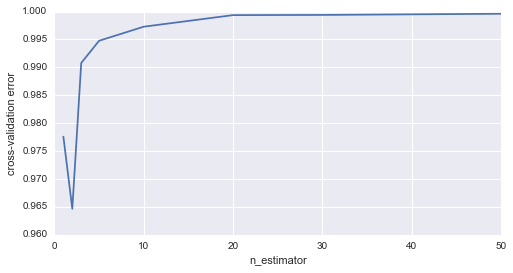

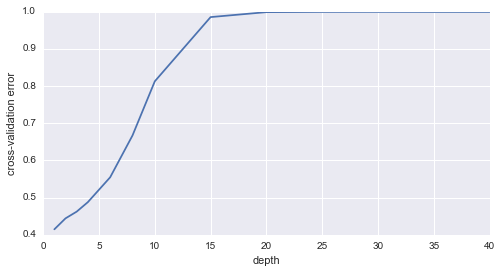

In [29]:
plot_cross_validation_error(n_estimators_range, k_scores, xlabelStr='n_estimator')
plot_cross_validation_error(depth_range, k_scores_depth, xlabelStr='depth')

In [30]:
#n_estimators_range = n_estimators_range[1:6]
#n_estimators_range.extend([20,30])
n_estimators_range = [1, 2, 3, 5, 10, 20, 30, 50]
len(n_estimators_range)
len(k_scores)

8

In [31]:
forest = RandomForestClassifier(n_estimators = 20)
scores = cross_val_score(forest, X, y1, cv=10, scoring=f1_score_modif)

In [32]:
forest = RandomForestClassifier(n_estimators = 20)
forest.fit(X,y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
featureNames = X.columns
def info_and_plot_feature_importances(forest):

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1] # backward order

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature '%s' (feature index %d) (%f)" % (f + 1, featureNames[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()


Feature ranking:
1. feature 'photoID' (feature index 16) (0.135389)
2. feature 'birthday' (feature index 4) (0.125585)
3. feature 'player' (feature index 1) (0.123950)
4. feature 'playerShort' (feature index 0) (0.121710)
5. feature 'club' (feature index 2) (0.118742)
6. feature 'weight' (feature index 6) (0.106435)
7. feature 'height' (feature index 5) (0.103674)
8. feature 'position' (feature index 7) (0.084964)
9. feature 'leagueCountry' (feature index 3) (0.037280)
10. feature 'meanIAT' (feature index 19) (0.005022)
11. feature 'nIAT' (feature index 20) (0.004626)
12. feature 'meanExp' (feature index 22) (0.004525)
13. feature 'nExp' (feature index 23) (0.004243)
14. feature 'Alpha_3' (feature index 18) (0.003594)
15. feature 'games' (feature index 8) (0.003173)
16. feature 'seIAT' (feature index 21) (0.003134)
17. feature 'seExp' (feature index 24) (0.002814)
18. feature 'goals' (feature index 12) (0.002395)
19. feature 'refNum' (feature index 17) (0.002335)
20. feature 'victories

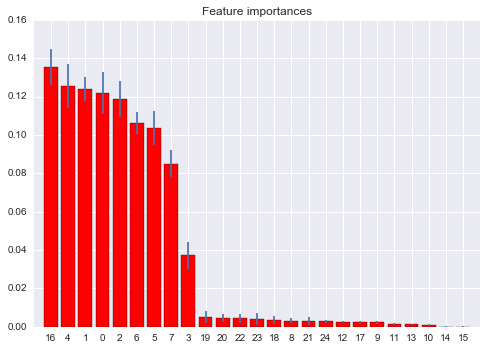

In [34]:
info_and_plot_feature_importances(forest)

# Task 2

In [35]:
from sklearn.cluster import KMeans

In [36]:
kmeansClassifier = KMeans(n_clusters=2)
kmeansClassifier.fit(X)
yPred = kmeansClassifier.predict(X)
yPred
pd.unique(pd.Series(yPred))
#metrics.accuracy_score(y, y_pred))

array([0, 1])

In [37]:
def clusterAssignmentAccuracy(estimator, X, y_true):
    y_pred = estimator.predict(X)
    
    #print(y_pred)
    #print(y_true)
    
    # we have to take the minimum because the cluster assignment is ambiguous
    agreeingEntries = (np.array(y_pred) == np.array(y_true))
    disAgreeingEntries = (np.array(y_pred) != np.array(y_true))
    fractionAgreeing = sum(agreeingEntries)/len(agreeingEntries)
    fractionDisagreeing = sum(disAgreeingEntries)/len(disAgreeingEntries)
    
    return max(fractionAgreeing, fractionDisagreeing)

In [38]:
yBlackBinary = y_avg
yBlackBinary[y_avg >= 4] = 0
yBlackBinary[y_avg < 4] = 1
#yBlackBinary = np.asarray(yBlackBinary)

In [39]:


pas_vals = [2]
score_clustering = []
for pas in pas_vals:
    print("Doing pas={}".format(pas))
    kmeansClassifier = KMeans(n_clusters=2)
    scores = cross_val_score(kmeansClassifier, X, yBlackBinary, cv=10, scoring=clusterAssignmentAccuracy)
    print(scores)
    score_clustering.append(scores.mean())
print(score_clustering)

Doing pas=2
[ 1.          0.99481865  1.          0.99762867  0.98735289  0.99727736
  0.99393993  1.          0.9957843   0.99604778]
[0.99628495680087092]


In [40]:
score_clustering

[0.99628495680087092]